## other idea
remove duplicates using running time 
    -> problem because same movies have 1 minute difference in running time in the two data sets
try to use anoter dataset than basics that has things in common with our dataset for removal of duplicates

### Ideal
finding mapping between movie id

data set:
https://datasets.imdbws.com/

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import json
import holoviews as hv
from holoviews import opts
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde

In [3]:
movie = pd.read_csv("data/movie.metadata.tsv", delimiter='\t',header=None)
character = pd.read_csv("data/character.metadata.tsv", delimiter='\t',header=None)
movie.columns = ['Wikipedia movie ID','Freebase movie ID','Movie name','Movie release date','Movie box office revenue','Movie runtime','Movie languages','Movie countries','Movie genres']
movie["Movie name"] = movie["Movie name"].str.capitalize()
movie["Movie name"] = movie["Movie name"].str.replace(r'[éè]', 'e', regex=True)

In [4]:
# imdb1 has ratings, imdb identifier and number of votes
imdb1 = pd.read_csv('data/title.ratings.tsv', delimiter='\t')

# imdb2 has genres, title, year, etc
imdb2 = pd.read_csv('data/title.basics.tsv', delimiter='\t', low_memory=False)
merged_df = pd.merge(imdb1, imdb2, on='tconst', how='inner')

# in the imdb data set they include series and a lot of other things.
#  This removes a lot of movies that are not in the other data 
merged_2 = merged_df[(merged_df.titleType == 'movie')|(merged_df.titleType == 'tvMovie')]

# removing all the movies that have less than 30 votes 
# questionable step because some of the movies in our data set have 
# very low amount of votes
merged_3= merged_2[merged_2['numVotes'] >= 30]

# making the titles of the movies in the same format for both data set 
# for example in one data set a movie can be called "The matrix" and in the other "The Matrix"
merged_3.loc[:, 'primaryTitle'] = merged_3['primaryTitle'].str.capitalize()

In [5]:
# removing all the columns that are not needed
merged_4 = merged_3.drop(columns=['numVotes' ,'titleType', 'isAdult', 'endYear', 'originalTitle', 'runtimeMinutes', 'genres', 'tconst'])

# merging the data sets on our movie data set
merged_final = pd.merge(merged_4, movie, left_on='primaryTitle', right_on='Movie name', how='right')

# creating a column that has the year of the movie release so that we can remove duplicates 
# that have the same name but different release year
merged_final["Movie release year"] = merged_final["Movie release date"].str[:4]

# trying to remove duplicates
merged_final2 = merged_final[merged_final['Movie release year']==merged_final['startYear']]

# drop colllumn that are not needed
merged_final2 = merged_final2.drop(columns=['primaryTitle', 'startYear', 'Movie release date'])
merged_final2 = merged_final2[merged_final2['Movie box office revenue'].notna()]

# The best data right now

In [6]:
merged_final2 = merged_final2.drop(merged_final2[merged_final2['Movie box office revenue'].isnull()].index)
merged_final['startYear'] = pd.to_numeric(merged_final['startYear'], errors='coerce').astype('Int64')

In [7]:
inflation = pd.read_excel('data/CPI-US-Iflation.xlsx',header=None)
inflation.columns = ['Year','CPI']
inflation['rate'] = 1
inflation = inflation.drop(inflation[inflation['Year'] > 2020].index)

#calculate the currency rate
for i in range(len(inflation)):
    inf = 1
    for j in range(len(inflation)-1,i,-1):
        inf = (1 + inflation['CPI'].iloc[j]/100.0)*inf
    inflation['rate'].iloc[i] = inf

C:\Users\15549\AppData\Local\Temp\ipykernel_14152\1032983450.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  inflation['rate'].iloc[i] = inf
C:\Users\15549\AppData\Local\Temp\ipykernel_14152\1032983450.py:11: SettingWithCopyWarning: 
A 

C:\Users\15549\AppData\Local\Temp\ipykernel_14152\3612643050.py:25: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


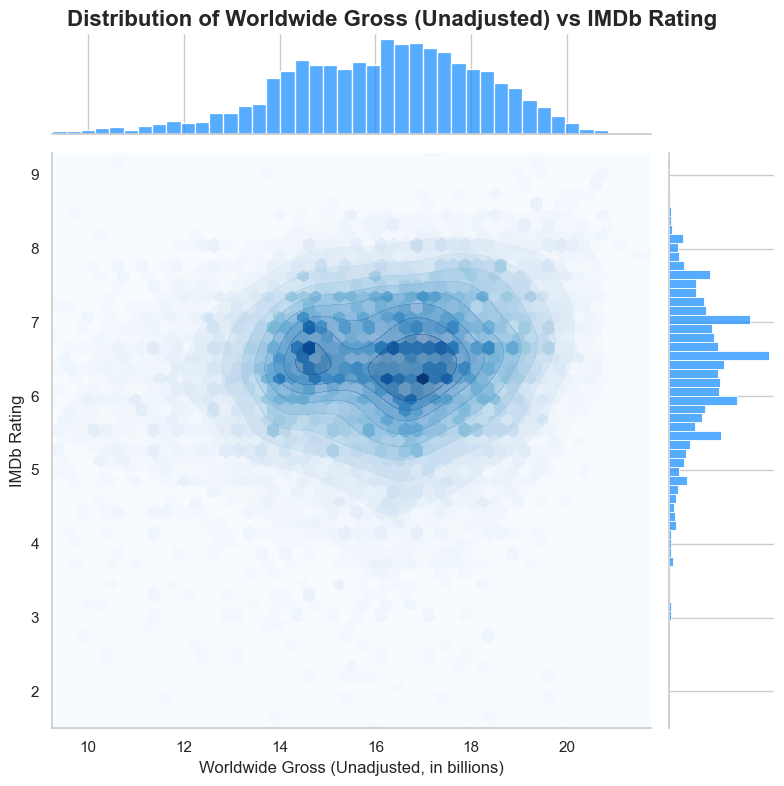

In [8]:
# Apply a log transformation (adding 1 to avoid log(0)) on the 'Movie box office revenue' column
# and store the result in a new column 'logMovieboxofficerevenue_unadjusted'
merged_final2['logMovieboxofficerevenue_unadjusted'] = np.log1p(merged_final2['Movie box office revenue'])

# Drop rows where 'logMovieboxofficerevenue_unadjusted' contains NaN values to avoid missing data in the plot
merged_final2.drop(merged_final2[merged_final2['logMovieboxofficerevenue_unadjusted'].isnull()].index, inplace=True)

# Set the Seaborn theme style to white grid and use a muted color palette
sns.set_theme(style="whitegrid", palette="muted")

# Create a joint plot with Seaborn, with a hexbin plot as the main part of the chart
g = sns.jointplot(data=merged_final2, x='logMovieboxofficerevenue_unadjusted', y='averageRating', kind="hex", cmap="Blues", height=8, gridsize=50, marginal_kws=dict(color="dodgerblue"))

# Overlay a density contour plot in the center area of the joint plot to show distribution contours
sns.kdeplot(data=merged_final2, x='logMovieboxofficerevenue_unadjusted', y='averageRating', cmap="Blues", fill=True, alpha=0.4, ax=g.ax_joint)

# Set the margins of the chart to fill the light blue background
g.ax_joint.margins(0)  # 移除四周的边距
g.ax_joint.set_xlim(merged_final2['logMovieboxofficerevenue_unadjusted'].min(), merged_final2['logMovieboxofficerevenue_unadjusted'].max())
g.ax_joint.set_ylim(merged_final2['averageRating'].min(), merged_final2['averageRating'].max())

# Set the title and labels of the plot and adjust the plot
g.fig.suptitle("Distribution of Worldwide Gross (Unadjusted) vs IMDb Rating", fontsize=16, weight='bold', ha='center')
g.set_axis_labels("Worldwide Gross (Unadjusted, in billions)", "IMDb Rating", fontsize=12)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)
plt.show()

In [9]:
import plotly.figure_factory as ff
import numpy as np

# 提取数据
x_data = merged_final2['logMovieboxofficerevenue_unadjusted']
y_data = merged_final2['averageRating']

# 创建 2D 密度图与边缘直方图
fig = ff.create_2d_density(
    x_data, y_data, colorscale="Blues",
    hist_color="#1E90FF",  # 边缘直方图颜色
    point_size=2,
)

# 设置图表布局和背景颜色
fig.update_layout(
    xaxis_title="Worldwide Gross (Unadjusted, in billions)",
    yaxis_title="IMDb Rating",
    title={
        'text': "Distribution of Worldwide Gross (Unadjusted) vs IMDb Rating",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 16}
    },
    template="simple_white",
    plot_bgcolor="rgba(173, 216, 230, 0.3)",  # 设置浅蓝色背景
    xaxis=dict(showline=False, showgrid=False, zeroline=False),  # 移除x轴的线
    yaxis=dict(showline=False, showgrid=False, zeroline=False),  # 移除y轴的线
    coloraxis_colorbar=dict(
        title="Density",
        titleside="right",
        thickness=15,
        len=0.5,
        ticks="outside",
    )
)

# 显示图表
fig.show()


In [10]:
#Perform an Ordinary Least Squares (OLS) regression using the statsmodels library. 
model_unadjusted = smf.ols(formula='logMovieboxofficerevenue_unadjusted ~ averageRating', data=merged_final2).fit(cov_type='HC2')
print(model_unadjusted.summary())

                                     OLS Regression Results                                    
Dep. Variable:     logMovieboxofficerevenue_unadjusted   R-squared:                       0.024
Model:                                             OLS   Adj. R-squared:                  0.023
Method:                                  Least Squares   F-statistic:                     165.0
Date:                                 Tue, 12 Nov 2024   Prob (F-statistic):           2.30e-37
Time:                                         00:03:03   Log-Likelihood:                -15996.
No. Observations:                                 7440   AIC:                         3.200e+04
Df Residuals:                                     7438   BIC:                         3.201e+04
Df Model:                                            1                                         
Covariance Type:                                   HC2                                         
                    coef    std err     

In [11]:
# Convert the 'Movie release year' column in merged_final2 to integer type
merged_final2['Movie release year'] = merged_final2['Movie release year'].astype('int')

# Convert the 'Year' column in the inflation DataFrame to integer type
inflation['Year'] = inflation['Year'].astype('int')

# Merge the inflation data with merged_final2 based on matching 'Year' and 'Movie release year' columns
merged_final2 = pd.merge(inflation, merged_final2, left_on='Year', right_on='Movie release year', how='right').drop(columns=['CPI'])

# Calculate the adjusted revenue by multiplying 'Movie box office revenue' by the inflation 'rate'
merged_final2['Adjusted_Revenue'] = merged_final2['Movie box office revenue']*merged_final2['rate']

C:\Users\15549\AppData\Local\Temp\ipykernel_14152\2534051059.py:12: UserWarning:

The figure layout has changed to tight



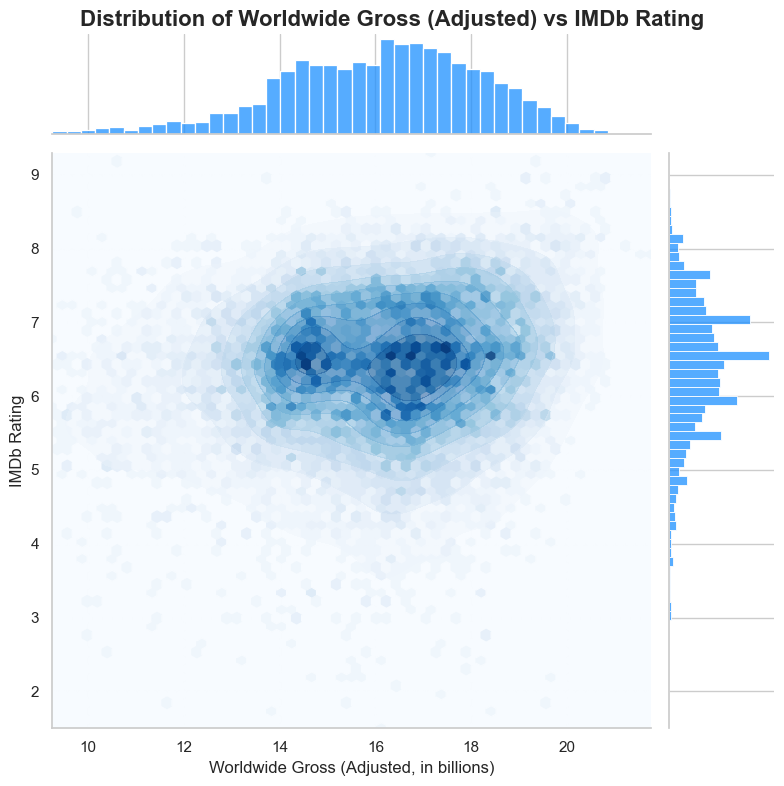

In [12]:
#Display the Adjusted World Gross vs. IMDb Rating plot with the same method when displaying Uadjusted World Gross vs. IMDb Rating plot
merged_final2['logMovieboxofficerevenue'] = np.log1p(merged_final2['Movie box office revenue'])
merged_final2.drop(merged_final2[merged_final2['logMovieboxofficerevenue'].isnull()].index, inplace=True)
sns.set_theme(style="whitegrid", palette="muted")
g = sns.jointplot(data=merged_final2, x='logMovieboxofficerevenue', y='averageRating', kind="hex", cmap="Blues", height=8,gridsize=60, marginal_kws=dict(color="dodgerblue"))
sns.kdeplot(data=merged_final2, x='logMovieboxofficerevenue', y='averageRating', cmap="Blues", fill=True, alpha=0.4, ax=g.ax_joint)
g.ax_joint.margins(0) 
g.ax_joint.set_xlim(merged_final2['logMovieboxofficerevenue'].min(), merged_final2['logMovieboxofficerevenue'].max())
g.ax_joint.set_ylim(merged_final2['averageRating'].min(), merged_final2['averageRating'].max())
g.fig.suptitle("Distribution of Worldwide Gross (Adjusted) vs IMDb Rating", fontsize=16, weight='bold', ha='center')
g.set_axis_labels("Worldwide Gross (Adjusted, in billions)", "IMDb Rating", fontsize=12)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)
plt.show()

In [13]:
#Perform an Ordinary Least Squares (OLS) regression using the statsmodels library. 
model = smf.ols(formula='logMovieboxofficerevenue ~ averageRating', data=merged_final2).fit(cov_type='HC2')
print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     logMovieboxofficerevenue   R-squared:                       0.024
Model:                                  OLS   Adj. R-squared:                  0.023
Method:                       Least Squares   F-statistic:                     165.0
Date:                      Tue, 12 Nov 2024   Prob (F-statistic):           2.30e-37
Time:                              00:03:05   Log-Likelihood:                -15996.
No. Observations:                      7440   AIC:                         3.200e+04
Df Residuals:                          7438   BIC:                         3.201e+04
Df Model:                                 1                                         
Covariance Type:                        HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

In [14]:
# Calculate the coefficients, predictions, and standard deviation
coefficients = model.params
predictions = model.predict()
std_dev = np.std(predictions - merged_final2['logMovieboxofficerevenue'])

# Create the plot with improved style and readability
scatter = hv.Scatter(merged_final2, 'averageRating', 'logMovieboxofficerevenue').opts(
    color='#3498DB', size=7, alpha=0.5, tools=['hover'], xlabel='Average Rating', ylabel='Log of Movie Box Office Revenue'
)

# Regression line and Standard Deviation lines
regression_line = hv.Curve((merged_final2['averageRating'], predictions), label='Regression Line').opts(color='orange', line_width=2)
std_dev_line_upper = hv.Curve((merged_final2['averageRating'], predictions + std_dev), label='+1 Std Dev').opts(color='green', line_dash='dashed', line_width=2)
std_dev_line_lower = hv.Curve((merged_final2['averageRating'], predictions - std_dev), label='-1 Std Dev').opts(color='red', line_dash='dashed', line_width=2)

# Integrate plots
layout = (scatter * regression_line * std_dev_line_upper * std_dev_line_lower).opts(
    title='Linear Regression of Log Box Office Revenue on Average Rating',
    width=800, height=500, legend_position='top_left'
)

layout


:Overlay
   .Scatter.I                    :Scatter   [averageRating]   (logMovieboxofficerevenue)
   .Curve.Regression_Line        :Curve   [x]   (y)
   .Curve.Plus_1_Std_Dev         :Curve   [x]   (y)
   .Curve.Hyphen_minus_1_Std_Dev :Curve   [x]   (y)

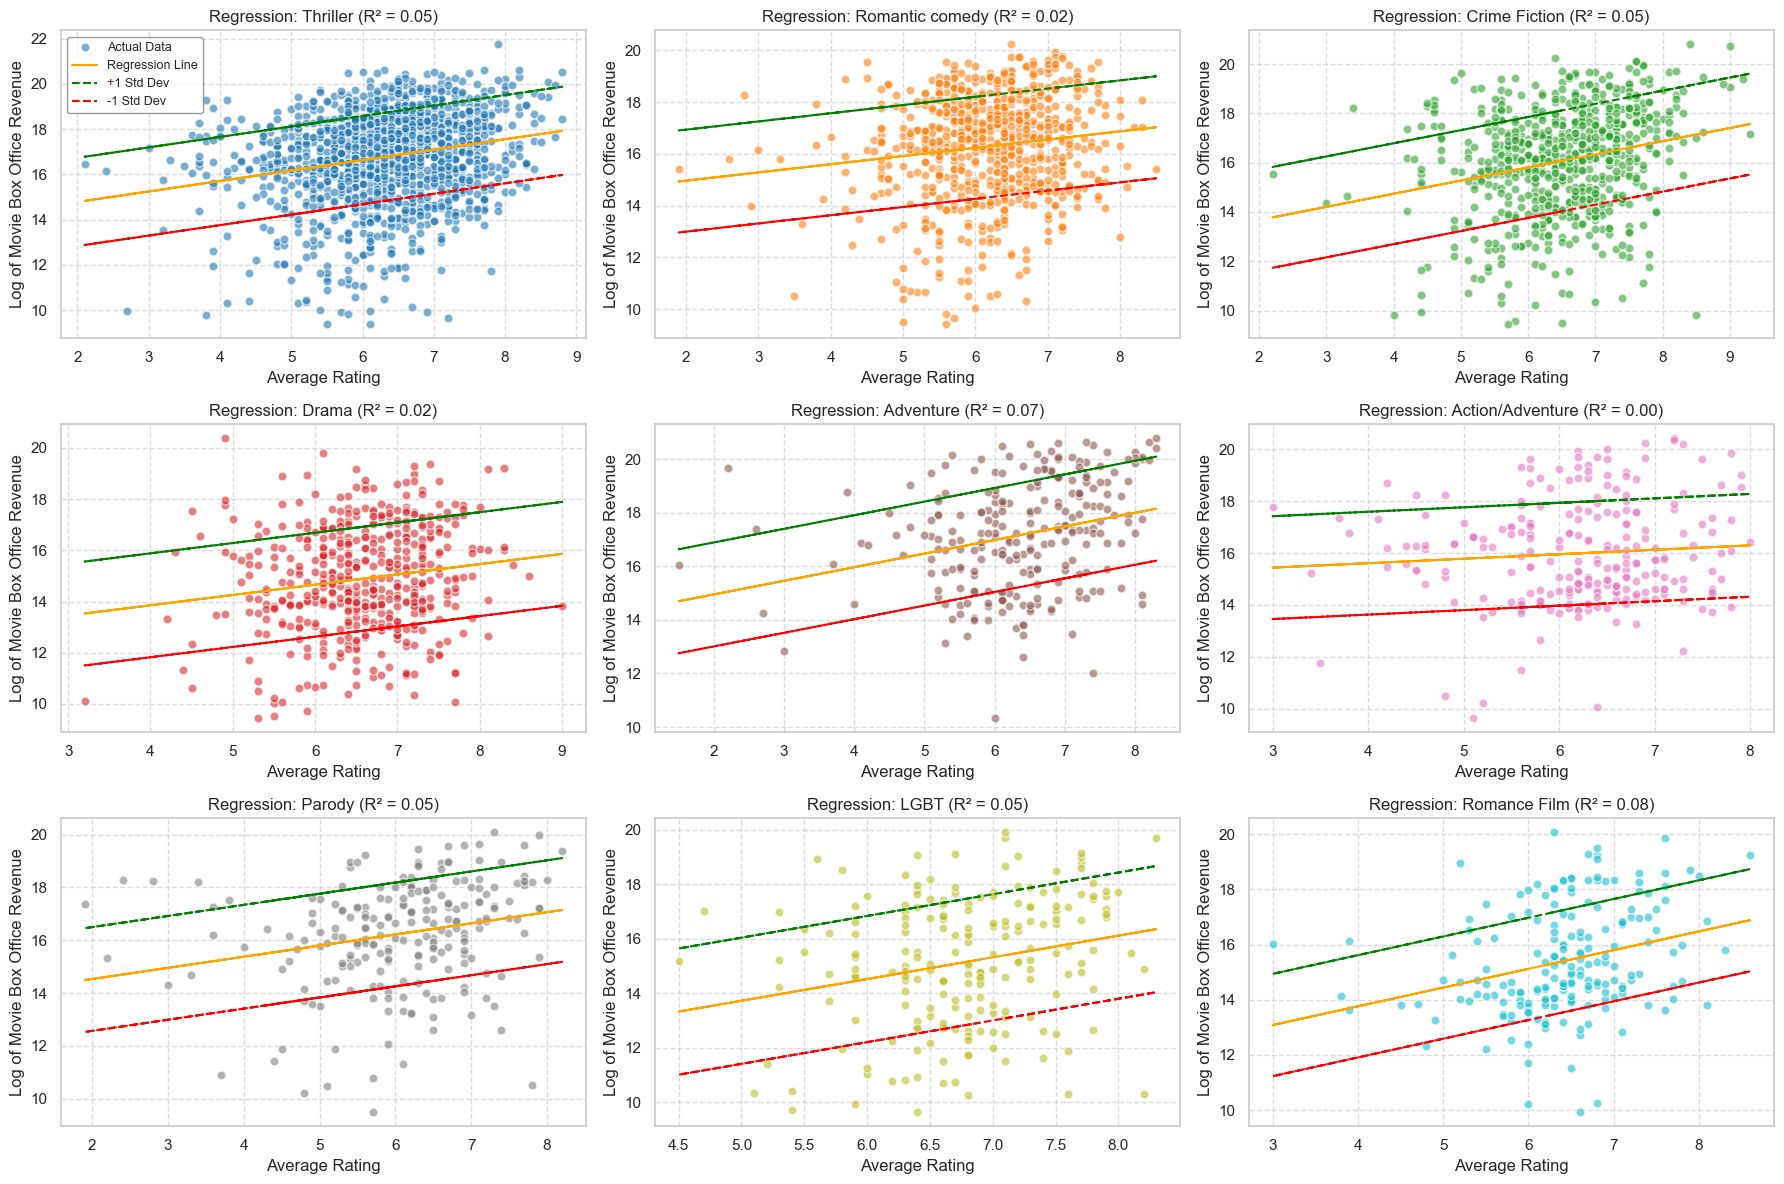

In [15]:
merged_final2['Movie countries'] = merged_final2['Movie genres'].apply(lambda x: list(json.loads(x).values()))
merged_final2['Primary Country'] = merged_final2['Movie countries'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
selected_countries = merged_final2['Primary Country'].value_counts().sort_values(ascending=False).head(9).index.tolist()
subset = merged_final2[merged_final2['Primary Country'].isin(selected_countries)]
colors_countries = plt.cm.tab10(np.linspace(0, 1, len(selected_countries)))

plt.figure(figsize=(18, 12))
for i, country in enumerate(selected_countries, 1):
    plt.subplot(3, 3, i)  
    country_data = subset[subset['Primary Country'] == country]
    model_countries = smf.ols(formula='logMovieboxofficerevenue ~ averageRating', data=country_data).fit(cov_type='HC2')
    coefficients_countries = model_countries.params
    predictions_countries = model_countries.predict()
    r2_score_countries = model_countries.rsquared_adj
    std_dev_countries = np.std(predictions_countries - country_data['logMovieboxofficerevenue'])
    plt.scatter(country_data['averageRating'], country_data['logMovieboxofficerevenue'], color=colors_countries[i - 1], alpha=0.6, s=40, edgecolor='white', label='Actual Data')
    plt.plot(country_data['averageRating'], predictions_countries, color='orange', label='Regression Line')
    plt.plot(country_data['averageRating'], predictions_countries + std_dev_countries, color='green', linestyle='--', label='+1 Std Dev')
    plt.plot(country_data['averageRating'], predictions_countries - std_dev_countries, color='red', linestyle='--', label='-1 Std Dev')
    plt.xlabel('Average Rating')
    plt.ylabel('Log of Movie Box Office Revenue')
    plt.title(f'Regression: {country} (R² = {r2_score_countries:.2f})')
    plt.grid(True, linestyle='--', alpha=0.7)
    if i == 1:  
        plt.legend(fontsize=9, loc='upper left', frameon=True, framealpha=0.8, edgecolor='gray')



plt.tight_layout()
plt.show()

d:\Jaco_Lam\E5\2024.8.19\Applied_Data_Analysis\Conda\ada\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning:

invalid value encountered in divide

d:\Jaco_Lam\E5\2024.8.19\Applied_Data_Analysis\Conda\ada\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning:

divide by zero encountered in scalar divide

d:\Jaco_Lam\E5\2024.8.19\Applied_Data_Analysis\Conda\ada\Lib\site-packages\statsmodels\regression\linear_model.py:2003: RuntimeWarning:

divide by zero encountered in divide



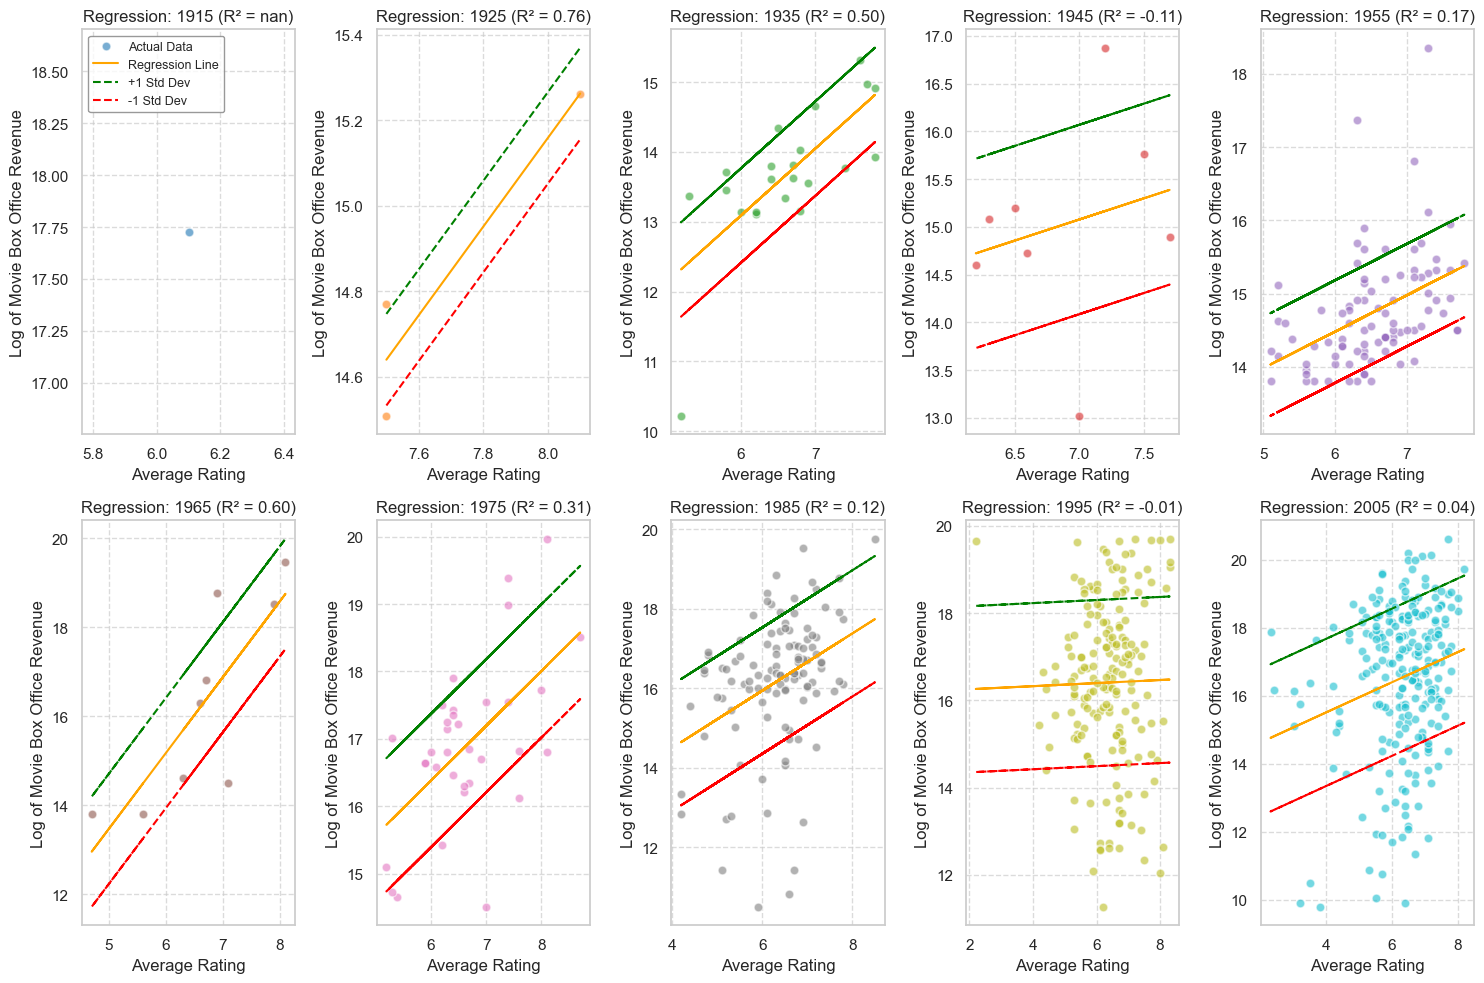

In [17]:
merged_final2['Year'].max()
selected_years = range(1915,2015,10)
subset = merged_final2[merged_final2['Year'].isin(selected_years)]
colors_years = plt.cm.tab10(np.linspace(0, 1, len(selected_years)))
plt.figure(figsize=(15, 10))

for i, year in enumerate(selected_years, 1):
    plt.subplot(2, 5, i)  
    year_data = subset[subset['Year'] == year]
    model_years = smf.ols(formula='logMovieboxofficerevenue ~ averageRating', data=year_data).fit(cov_type='HC2')
    coefficients_years = model_years.params
    predictions_years = model_years.predict()
    r2_score_years = model_years.rsquared_adj
    std_dev_years = np.std(predictions_years - year_data['logMovieboxofficerevenue'])
    plt.scatter(year_data['averageRating'], year_data['logMovieboxofficerevenue'], color=colors_years[i - 1], alpha=0.6, s=40, edgecolor='white', label='Actual Data')
    plt.plot(year_data['averageRating'], predictions_years, color='orange', label='Regression Line')
    plt.plot(year_data['averageRating'], predictions_years + std_dev_years, color='green', linestyle='--', label='+1 Std Dev')
    plt.plot(year_data['averageRating'], predictions_years - std_dev_years, color='red', linestyle='--', label='-1 Std Dev')
    plt.xlabel('Average Rating')
    plt.ylabel('Log of Movie Box Office Revenue')
    plt.title(f'Regression: {year} (R² = {r2_score_years:.2f})')
    plt.grid(True, linestyle='--', alpha=0.7)
    if i == 1:
        plt.legend(fontsize=9, loc='upper left', frameon=True, framealpha=0.8, edgecolor='gray')

plt.tight_layout()
plt.show()

In [18]:
residuals = merged_final2['logMovieboxofficerevenue'] - predictions
outliers = merged_final2[np.abs(residuals) > std_dev]['logMovieboxofficerevenue']
print(outliers.count())
higher = merged_final2[residuals > std_dev].copy()
lower = merged_final2[residuals < -std_dev].copy()
print('length of higher:',len(higher),'length of lower:',len(lower))

2371
length of higher: 1231 length of lower: 1140


In [19]:
higher['Movie genres'] = higher['Movie genres'].apply(lambda x: list(json.loads(x).values()) if isinstance(x, str) else x)
higher['Movie languages'] = higher['Movie languages'].apply(lambda x: list(json.loads(x).values()) if isinstance(x, str) else x)
higher['Movie countries'] = higher['Movie countries'].apply(lambda x: list(json.loads(x).values()) if isinstance(x, str) else x)

lower['Movie genres'] = lower['Movie genres'].apply(lambda x: list(json.loads(x).values()) if isinstance(x, str) else x)
lower['Movie languages'] = lower['Movie languages'].apply(lambda x: list(json.loads(x).values()) if isinstance(x, str) else x)
lower['Movie countries'] = lower['Movie countries'].apply(lambda x: list(json.loads(x).values()) if isinstance(x, str) else x)


In [20]:
higher.loc[:, 'First genre'] = higher['Movie genres'].apply(lambda x: x[0])
higher.loc[:, 'Second genre'] = higher['Movie genres'].apply(lambda x: x[1] if len(x) > 1 else None)
higher.loc[:, 'Third genre'] = higher['Movie genres'].apply(lambda x: x[2] if len(x) > 2 else None)

In [21]:
First_t10 = higher['First genre'].value_counts()
Second_t10 = higher['Second genre'].value_counts()
Third_t10 = higher['Third genre'].value_counts()
all_genres = pd.concat([higher['First genre'], higher['Second genre'], higher['Third genre']])
All_t10 = all_genres.value_counts().head(10)
All_t10

Thriller            452
Adventure           254
Crime Fiction       191
Science Fiction     186
Drama               172
Romantic comedy     143
Romance Film        143
Comedy              140
Action/Adventure    139
Horror              123
Name: count, dtype: int64

In [22]:
data = np.zeros((len(All_t10.index),3))
i = 0
for genre in All_t10.index:
    data[i,0] = First_t10.get(genre, 0)
    data[i,1] = Second_t10.get(genre, 0)
    data[i,2] = Third_t10.get(genre, 0)
    i = i + 1

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
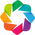

:Bars   [Category,Subcategory]   (Value)

In [23]:
hv.extension('bokeh')

# Example data
categories = list(All_t10.index)
values = np.concatenate([data[:, 0], data[:, 1], data[:, 2]])

# Ensure all arrays have the same length
data_dict = {
    'Category': np.tile(categories, 3),  # Repeat categories 3 times
    'Subcategory': ['First_t10'] * len(categories) + ['Second_t10'] * len(categories) + ['Third_t10'] * len(categories),
    'Value': values
}
df = pd.DataFrame(data_dict)

# Custom color mapping
color_map = {
    'First_t10': '#800080',   # Purple
    'Second_t10': '#00008B',  # Dark blue
    'Third_t10': '#87CEFA'    # Light blue
}

# Create stacked bar chart
bars = hv.Bars(df, ['Category', 'Subcategory'], 'Value')

# Set chart style
bars.opts(
    stacked=True,                      
    width=1000, height=500,            
    color=hv.Cycle(values=[color_map['First_t10'], color_map['Second_t10'], color_map['Third_t10']]), 
    title="HoloViews Interactive Stacked Bar Chart",
    tools=['hover'],                  
    toolbar='above',                   
    legend_position='top',             
    xrotation=45,                      
    padding=0.1                        
)

bars


In [24]:
higher['Number of genres'] = higher['Movie genres'].apply(lambda x: len(x) if isinstance(x, list) else 0)
higher['Number of genres'][higher['Number of genres']>3].count()

1060

In [25]:
# x=merged_final2['averageRating']
# x = (x -x.mean())/x.std()
# y=merged_final2['logMovieboxofficerevenue']
# y = (y -y.mean())/y.std()
# plt.hist(merged_final2['averageRating'])
# up=merged_final2['averageRating'].mean() + merged_final2['averageRating'].std()
# low=merged_final2['averageRating'].mean() - merged_final2['averageRating'].std()
# plt.hist(merged_final2['averageRating'])
# # Create an array of y values
# y = np.linspace(-10, 3000, 400)

# # Plot the vertical line x = 1
# plt.plot(up*np.ones_like(y), y, label="x = 1", color='red')
# plt.plot(low*np.ones_like(y), y, label="x = 1", color='red')
# merged_final2['averageRating'][(merged_final2['averageRating'] < up) & (merged_final2['averageRating'] > low)].count()
# merged_final2['averageRating']

In [26]:
# from sklearn.cluster import KMeans
# x=merged_final2['averageRating']
# x = (x -x.mean())/x.std()
# y=merged_final2['logMovieboxofficerevenue']
# y = (y -y.mean())/y.std()
# merged_final2['averageRating'] = (x - np.min(x)) / (np.max(x) - np.min(x))
# merged_final2['logMovieboxofficerevenue'] = (y - np.min(y)) / (np.max(y) - np.min(y))
# data = np.column_stack((x, y))
# #elbow
# sse = []
# k_range = range(1, 11)  
# for k in k_range:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(data)
#     sse.append(kmeans.inertia_)  
# plt.plot(k_range, sse, marker='o')
# plt.title('Elbow Method for Optimal k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('SSE (Inertia)')
# plt.show()

In [27]:
# kmeans = KMeans(n_clusters=4, random_state=42)  
# merged_final2['cluster'] = kmeans.fit_predict(data)  
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='averageRating', y='logMovieboxofficerevenue', hue='cluster', palette='Set1', data=merged_final2, s=100, edgecolor='black', marker='o')
# plt.title('K-means Clustering of 2D Data')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.legend(title='Cluster')
# plt.show()